In [53]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore') 

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from scipy import stats

%run utils.py

path = Path(os.getcwd()).parent

### GBS GIVEN GESIS

In [54]:
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')

gbs = gbs.fillna(gbs.median())
gesis = gesis.fillna(gesis.median())

gesis.drop(columns = ['GESIS-CODE'], axis=1, inplace = True)
gbs.drop(columns = ['GBS-CODE', 'Gruppe'], axis=1, inplace = True)

drop = ['Personen im Haushalt', 'Druck', 'Optimismus Zukunft', 'Geburtsland', 'Nationalitaet',
       'Familienstand', 'Hoechster Bildungsabschluss', 'Berufliche Ausbildung',
       'Berufsgruppe', 'Leben genießen', 'Zu Nichts aufraffen',
       'Alles anstrengend', 'Zufriedenheit Leben', 'Aktiv', 'Verärgert',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Wach', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'Nettoeinkommen Selbst', 'Nettoeinkommen Haushalt', 'Schlechter Schlaf',
       'Wahlabsicht', 'Desinteresse Politiker', 'Erwerbstaetigkeit',
       'leicht Vertrauen', 'Wahlteilnahme']

gbs.drop(columns=drop, axis=1, inplace=True)
gesis.drop(columns=drop, axis=1, inplace=True)

non_rep = gbs.copy(deep=True)
rep = gesis.copy(deep=True)

rep['label'] = 'rep'
non_rep['label'] = 'nonrep'

### GBS GIVEN ALLENSBACH

In [55]:
allensbach_cols = ['S01', 'S02', 'S03_rec', 'S05', 'V19']
allensbach_names = ['Geschlecht', 'Geburtsjahr', 'Hoechster Bildungsabschluss', 'Erwerbstaetigkeit',
                    'Soziale Unterstuetzung']

allensbach = pd.read_csv(os.path.join(path, 'data/Allensbach/abs_data.csv'),
                         usecols = allensbach_cols,
                         delimiter=';', low_memory=False)

allensbach.replace(',', '.', regex=True, inplace=True)
allensbach.replace(' ', np.nan, regex=True, inplace=True)

allensbach = allensbach.fillna(allensbach.median()) # quick fix, for the time being.
allensbach.rename(columns= dict(zip(allensbach_cols, allensbach_names)), inplace=True)

gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

# Rename 'GBS-CODE' column
key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

# Merge GBS "Umfrage Wellen" and create dataframe
gbs = pd.merge(gbs1, gbs2, how='inner', on=key)
gbs = pd.merge(gbs, mapping1, how='left', on=key)
gbs = pd.merge(gbs, mapping2, how='left', on=key)

gbs_cols = ['am01', 'am02_01', 'am14', 'am17', 'os03']
allensbach_names = ['Geschlecht', 'Geburtsjahr', 'Hoechster Bildungsabschluss', 
                    'Erwerbstaetigkeit', 'Soziale Unterstuetzung',]

gbs = gbs[gbs_cols]
gbs.rename(columns= dict(zip(gbs_cols, allensbach_names)), inplace=True)

del mapping1, mapping2, gbs1, gbs2

# TODO: Combine matching rows instead of selecting every 2nd.
gbs = gbs.iloc[::2, :]

di1 = {'männlich': 1, "Männlich": 1, 'weiblich': 2, "Weiblich": 2, '[NA] Keine Angabe':np.nan}
gbs.replace({"Geschlecht": di1}, inplace=True)

gbs['Geburtsjahr'] = [2017-(int)(gj[:4]) if gj is not np.nan else np.nan for gj in gbs.Geburtsjahr]

di2 = {'Hochschulabschluss':5, 
       'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 4, 
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 4, 
       'Realschulabschluss (Mittlere Reife)': 3,
       'Hauptschulabschluss/Volksschulabschluss': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 1, 
       'Anderer Schulabschluss:': 1}

gbs.replace({'Hoechster Bildungsabschluss': di2}, inplace=True)

di3 = {9:2,
       999:2,
      -3:2,
      -1:2,
      3:2}

# Note: this is also allensbach replacement using same dict
allensbach = allensbach.replace({'Erwerbstaetigkeit': di3})
allensbach['Erwerbstaetigkeit'] = [int(i) for i in allensbach.Erwerbstaetigkeit]

di4 = {'sehr viel Anteilnahme und Interesse':5, 
       'viel Anteilnahme und Interesse': 4, 
       'weder viel noch wenig': 3, 
       'wenig Anteilnahme und Interesse': 2, 
       'keine Anteilnahme und Interesse': 1,
       'keine Angabe':3}
gbs.replace({'Soziale Unterstuetzung': di4}, inplace=True)

In [56]:
data = pd.concat([rep, non_rep], sort=True).copy(deep=True) # gesis and gbs

data = data.fillna(data.median()) # quick fix, for the time being.
data['probs'] = len(data.label)*[0]


data.reset_index(inplace=True, drop=True)
data.head()

Andere kritisieren  Entspannt  Faulheit  Geburtsjahr  Geschlecht  Gesellig  \
0                 3.0        3.0       1.0       1946.0         0.0       4.0   
1                 3.0        1.0       2.0       1974.0         1.0       1.0   
2                 3.0        3.0       2.0       1994.0         1.0       4.0   
3                 3.0        2.0       3.0       1950.0         0.0       3.0   
4                 4.0        2.0       3.0       1990.0         0.0       2.0   

   Gruendlich  Nervoes  Phantasievoll label  wenig kuenstlerisches Interesse  \
0         4.0      3.0            4.0   rep                              4.0   
1         4.0      5.0            1.0   rep                              5.0   
2         4.0      3.0            4.0   rep                              3.0   
3         4.0      3.0            4.0   rep                              2.0   
4         4.0      5.0            3.0   rep                              4.0   

   probs  
0      0  
1      0  
2      0  
3      0  
4      0

In [57]:
allensbach['label'] = 'rep'
gbs['label'] = 'nonrep'

test_rep = allensbach.copy(deep=True)
test_non_rep = gbs.copy(deep=True)

test = pd.concat([test_rep, test_non_rep], sort=True).copy(deep=True)

test = test.fillna(test.median()) # quick fix, for the time being.
test.reset_index(drop=True, inplace=True)

test['probs'] = len(test.label)*[0]
test.head()

Erwerbstaetigkeit Geburtsjahr  Geschlecht Hoechster Bildungsabschluss  \
0                2.0          73         2.0                           2   
1                1.0          24         2.0                           3   
2                1.0          51         1.0                           3   
3                1.0          57         1.0                           5   
4                2.0          64         1.0                           2   

  Soziale Unterstuetzung label  probs  
0                      3   rep      0  
1                      2   rep      0  
2                      4   rep      0  
3                      2   rep      0  
4                      4   rep      0

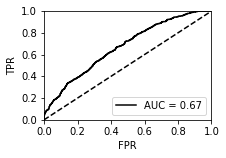

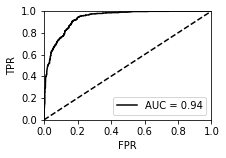

length of current GBS subset: 578


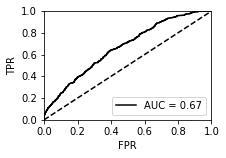

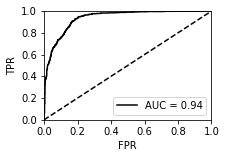

length of current GBS subset: 577


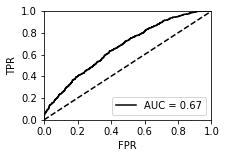

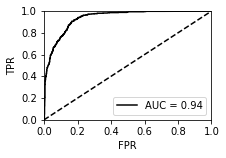

length of current GBS subset: 576


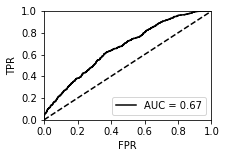

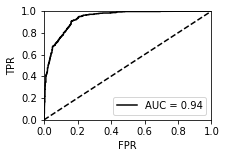

length of current GBS subset: 575


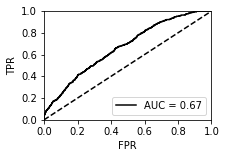

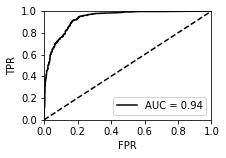

length of current GBS subset: 574


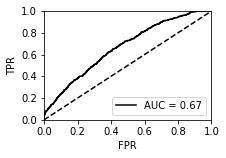

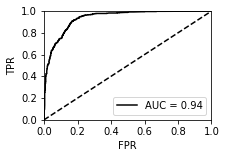

length of current GBS subset: 573


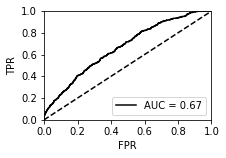

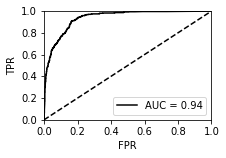

length of current GBS subset: 572


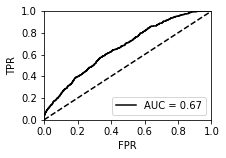

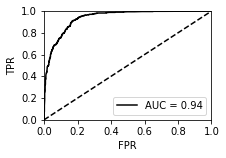

length of current GBS subset: 571


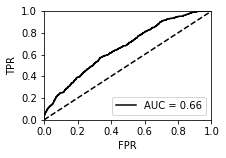

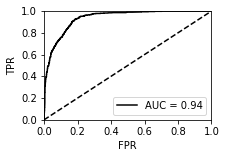

length of current GBS subset: 570


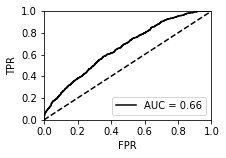

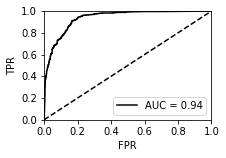

length of current GBS subset: 569


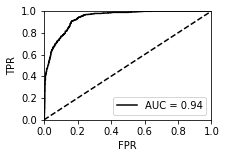

length of current GBS subset: 568


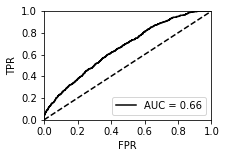

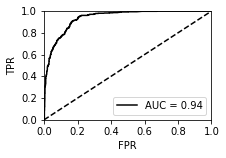

length of current GBS subset: 567


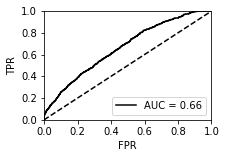

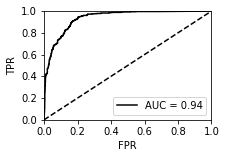

length of current GBS subset: 566


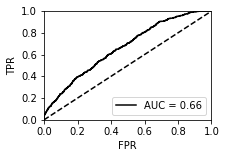

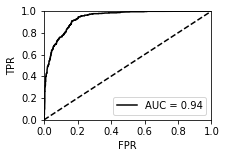

length of current GBS subset: 565


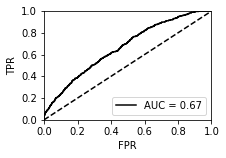

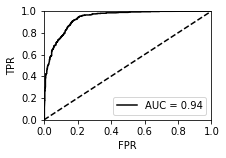

length of current GBS subset: 564


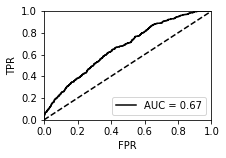

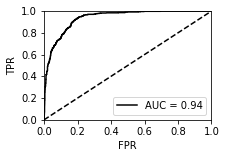

length of current GBS subset: 563


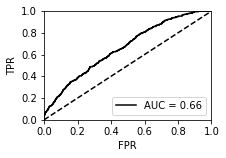

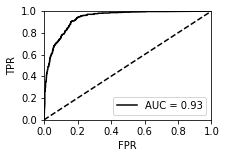

length of current GBS subset: 562


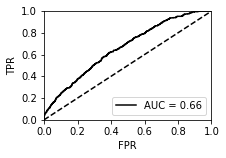

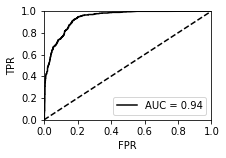

length of current GBS subset: 561


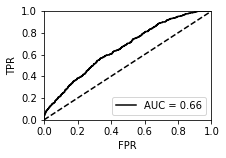

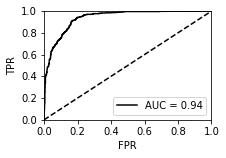

length of current GBS subset: 560


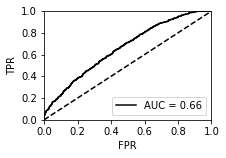

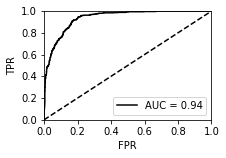

length of current GBS subset: 559


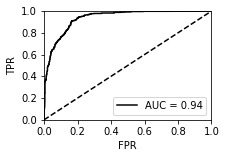

length of current GBS subset: 558


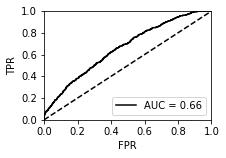

length of current GBS subset: 557


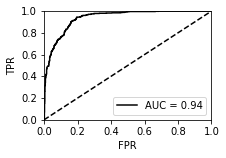

length of current GBS subset: 556


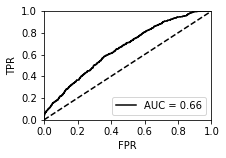

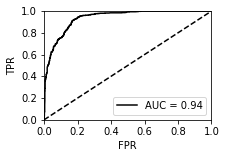

length of current GBS subset: 555


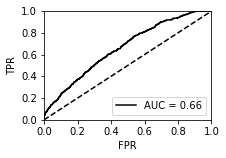

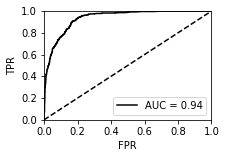

length of current GBS subset: 554


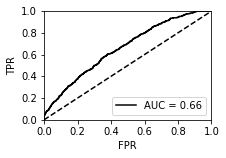

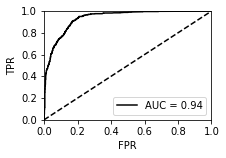

length of current GBS subset: 553


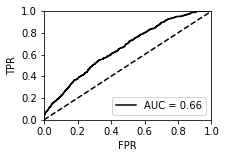

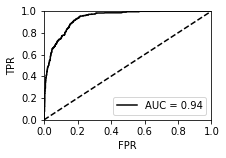

length of current GBS subset: 552


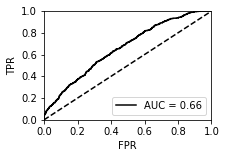

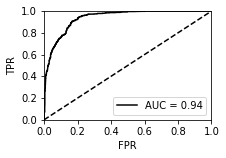

length of current GBS subset: 551


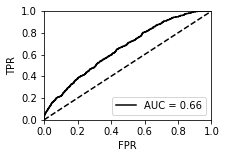

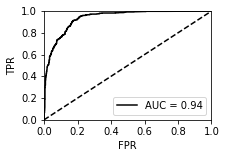

length of current GBS subset: 550


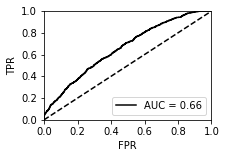

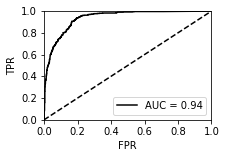

length of current GBS subset: 549


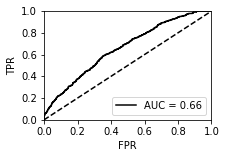

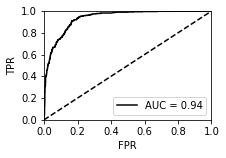

length of current GBS subset: 548


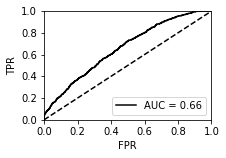

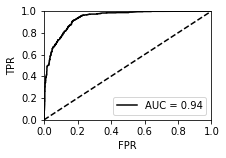

length of current GBS subset: 547


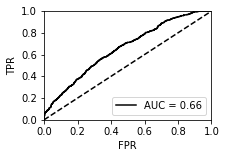

length of current GBS subset: 546


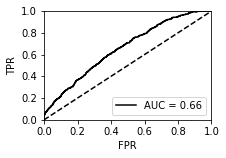

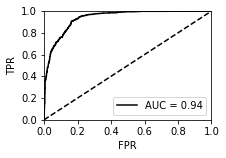

length of current GBS subset: 545


length of current GBS subset: 544


length of current GBS subset: 543


length of current GBS subset: 542


length of current GBS subset: 541


length of current GBS subset: 540


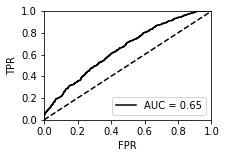

length of current GBS subset: 539


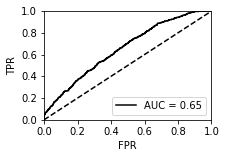

length of current GBS subset: 538


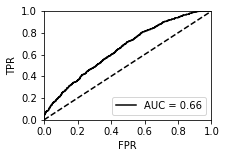

length of current GBS subset: 537


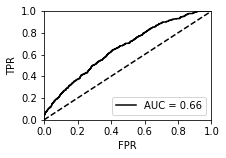

length of current GBS subset: 536


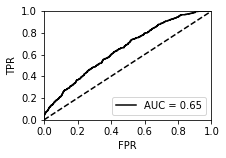

length of current GBS subset: 535


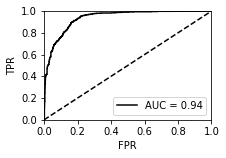

length of current GBS subset: 534


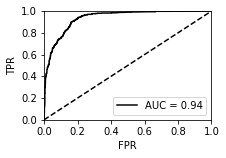

length of current GBS subset: 533


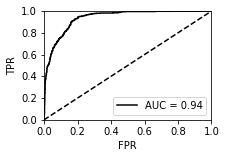

length of current GBS subset: 532


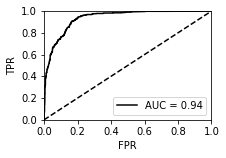

length of current GBS subset: 531


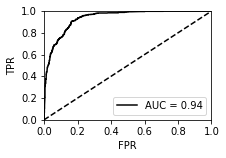

length of current GBS subset: 530


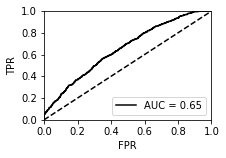

length of current GBS subset: 529


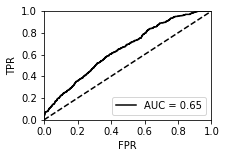

length of current GBS subset: 528


length of current GBS subset: 527


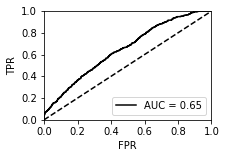

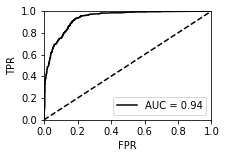

length of current GBS subset: 526


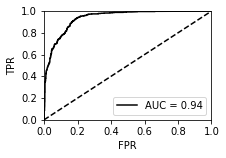

length of current GBS subset: 525


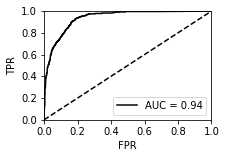

length of current GBS subset: 524


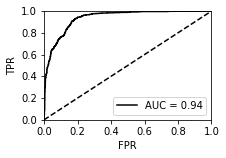

length of current GBS subset: 523


length of current GBS subset: 522


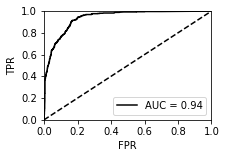

length of current GBS subset: 521


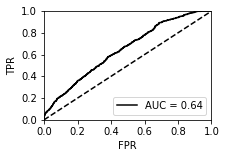

length of current GBS subset: 520


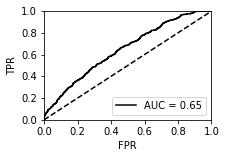

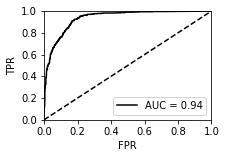

length of current GBS subset: 519


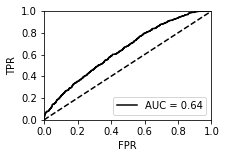

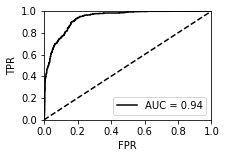

length of current GBS subset: 518


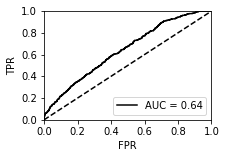

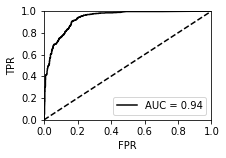

length of current GBS subset: 517


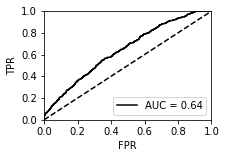

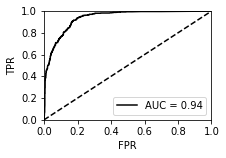

length of current GBS subset: 516


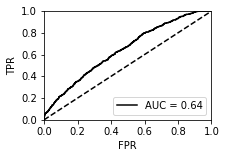

length of current GBS subset: 515


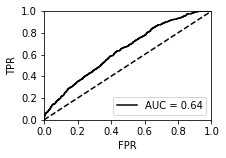

length of current GBS subset: 514


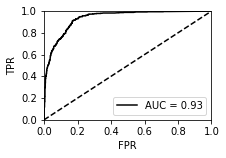

length of current GBS subset: 513


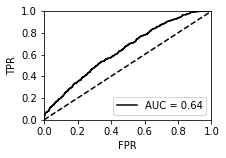

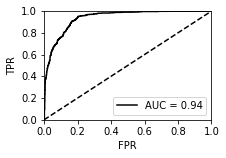

length of current GBS subset: 512


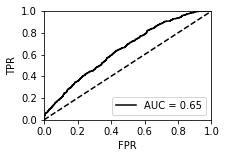

length of current GBS subset: 511


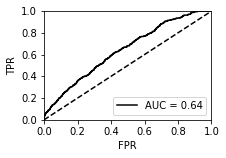

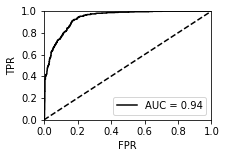

length of current GBS subset: 510


length of current GBS subset: 509


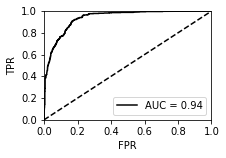

length of current GBS subset: 508


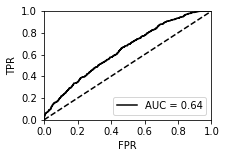

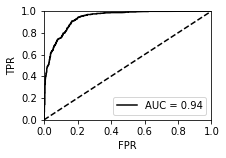

length of current GBS subset: 507


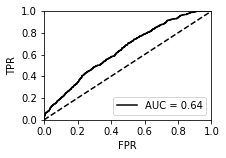

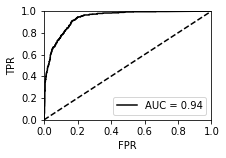

length of current GBS subset: 506


length of current GBS subset: 505


length of current GBS subset: 504


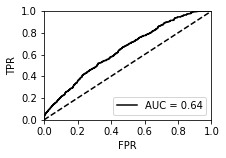

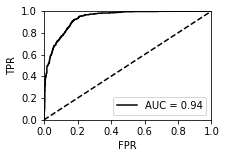

length of current GBS subset: 503


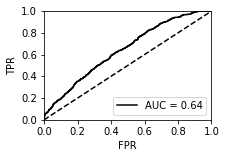

length of current GBS subset: 502


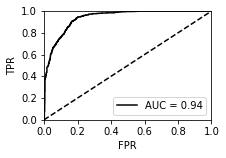

length of current GBS subset: 501


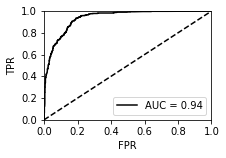

length of current GBS subset: 500


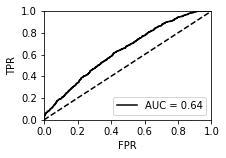

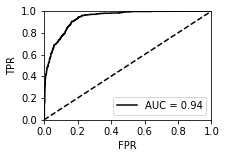

length of current GBS subset: 499


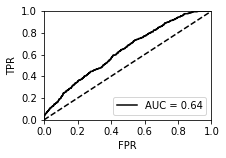

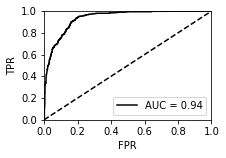

length of current GBS subset: 498


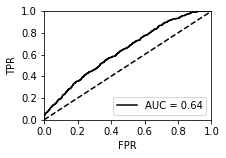

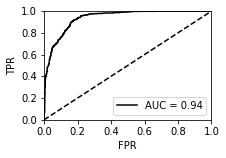

length of current GBS subset: 497


length of current GBS subset: 496


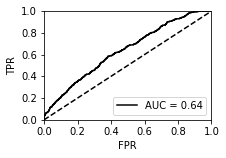

length of current GBS subset: 495


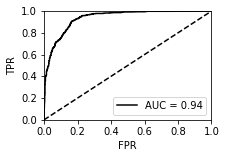

length of current GBS subset: 494


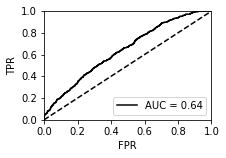

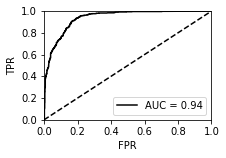

length of current GBS subset: 493


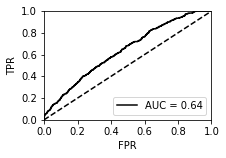

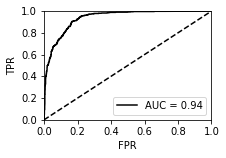

length of current GBS subset: 492


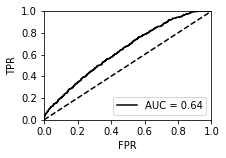

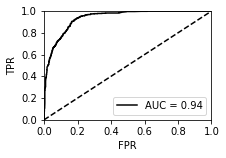

length of current GBS subset: 491


length of current GBS subset: 490


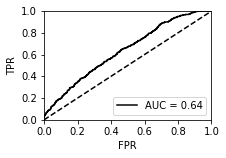

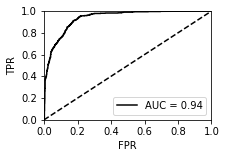

length of current GBS subset: 489


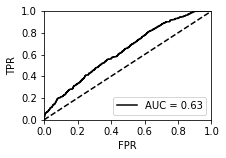

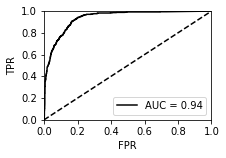

length of current GBS subset: 488


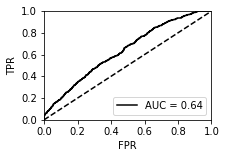

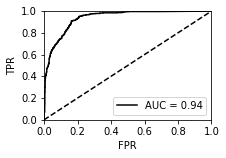

length of current GBS subset: 487


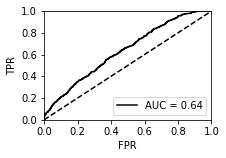

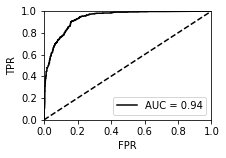

length of current GBS subset: 486


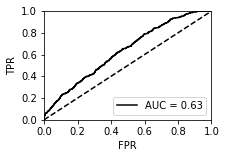

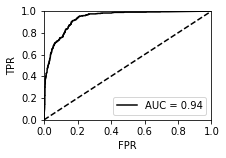

length of current GBS subset: 485


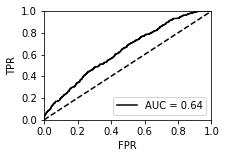

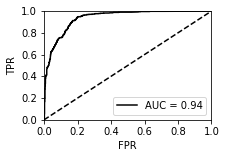

length of current GBS subset: 484


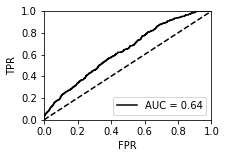

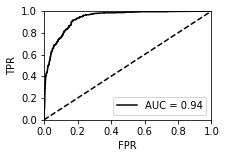

length of current GBS subset: 483


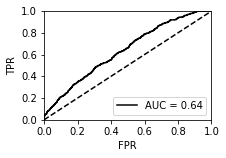

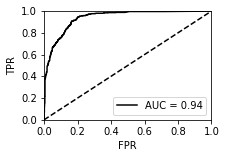

length of current GBS subset: 482


length of current GBS subset: 481


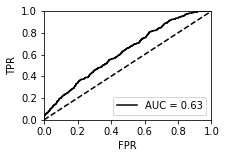

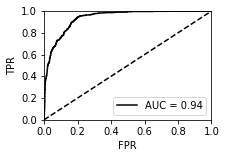

length of current GBS subset: 480


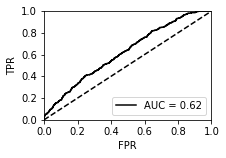

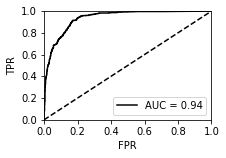

length of current GBS subset: 479


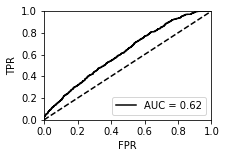

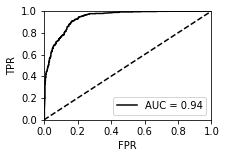

length of current GBS subset: 478


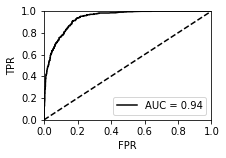

length of current GBS subset: 477


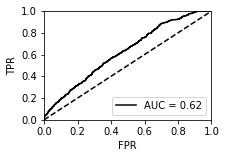

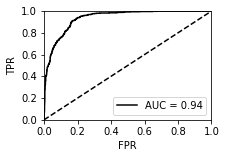

length of current GBS subset: 476


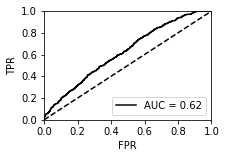

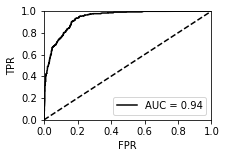

length of current GBS subset: 475


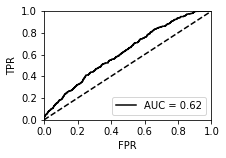

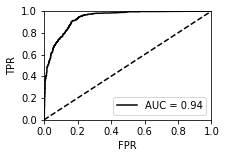

length of current GBS subset: 474


length of current GBS subset: 473


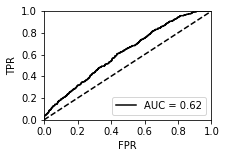

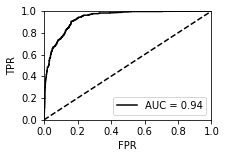

length of current GBS subset: 472


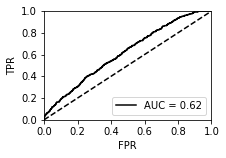

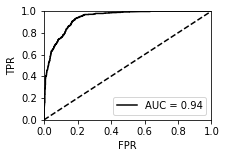

length of current GBS subset: 471


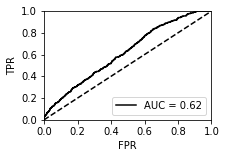

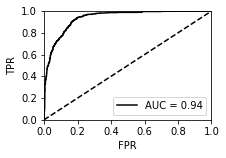

length of current GBS subset: 470


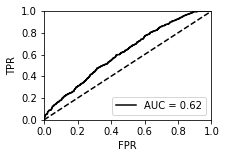

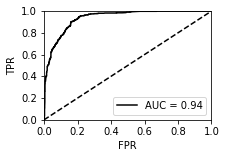

length of current GBS subset: 469


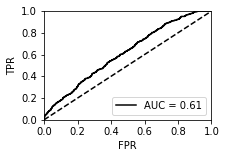

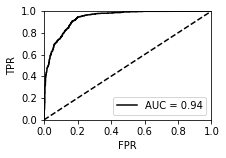

length of current GBS subset: 468


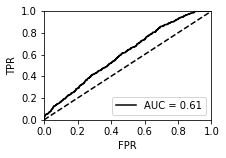

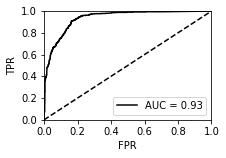

length of current GBS subset: 467


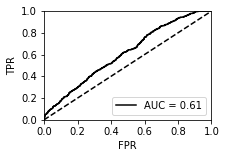

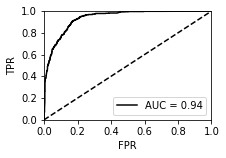

length of current GBS subset: 466


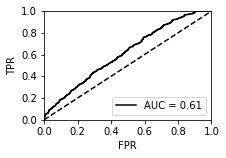

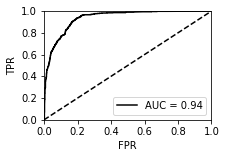

length of current GBS subset: 465


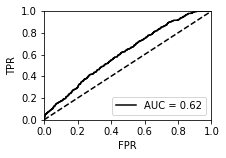

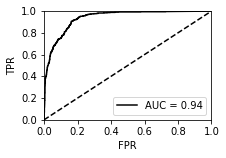

length of current GBS subset: 464


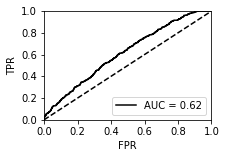

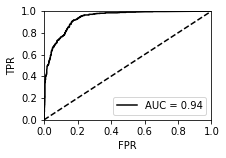

length of current GBS subset: 463


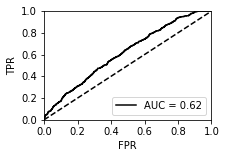

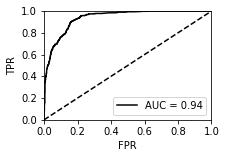

length of current GBS subset: 462


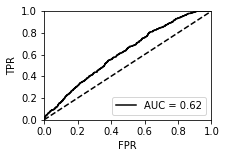

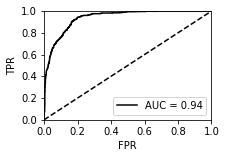

length of current GBS subset: 461


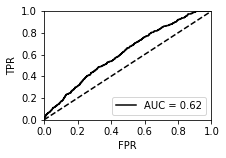

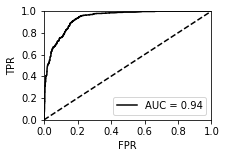

length of current GBS subset: 460


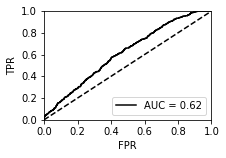

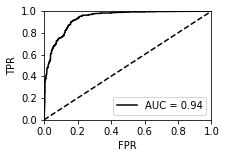

length of current GBS subset: 459


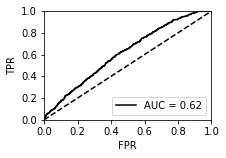

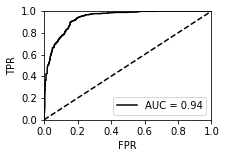

length of current GBS subset: 458


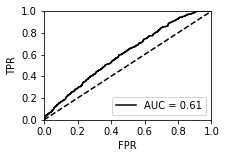

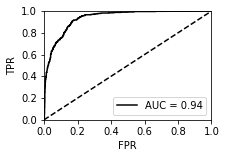

length of current GBS subset: 457


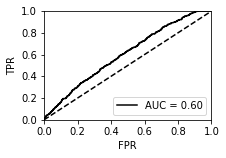

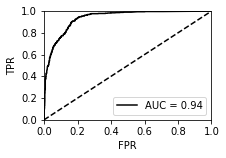

length of current GBS subset: 456


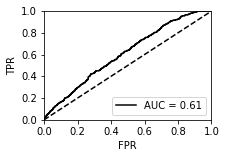

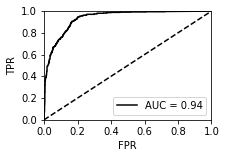

length of current GBS subset: 455


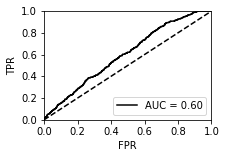

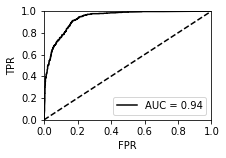

length of current GBS subset: 454


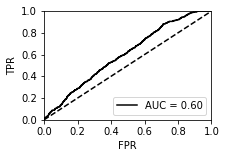

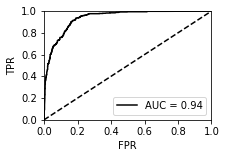

length of current GBS subset: 453


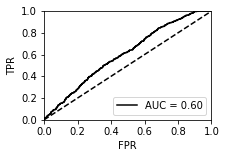

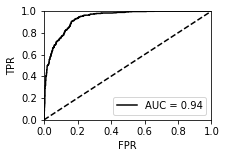

length of current GBS subset: 452


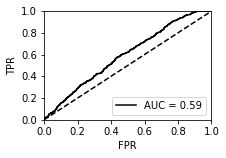

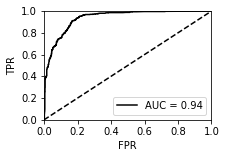

length of current GBS subset: 451


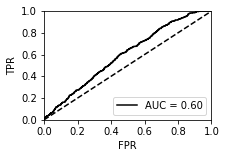

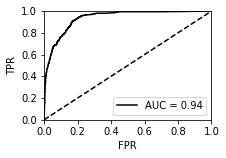

length of current GBS subset: 450


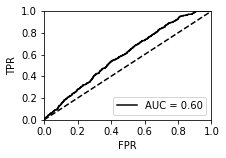

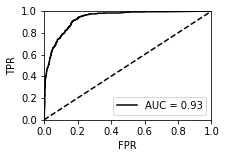

length of current GBS subset: 449


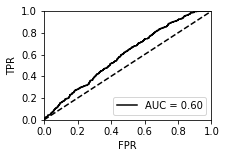

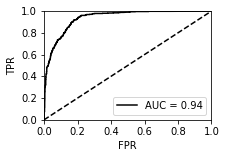

length of current GBS subset: 448


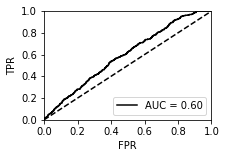

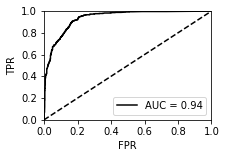

length of current GBS subset: 447


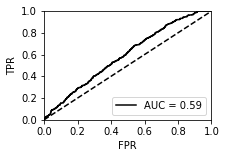

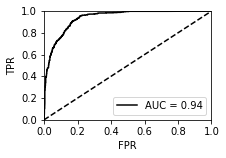

length of current GBS subset: 446


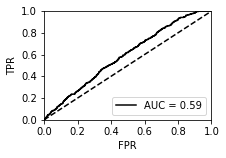

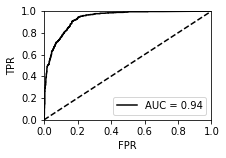

length of current GBS subset: 445


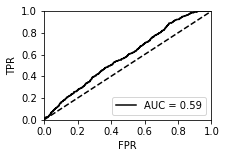

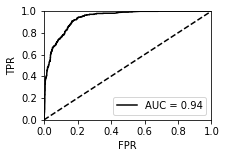

length of current GBS subset: 444


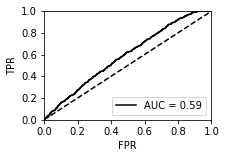

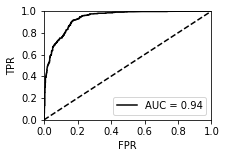

length of current GBS subset: 443


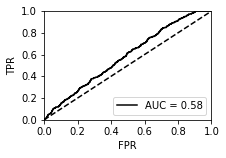

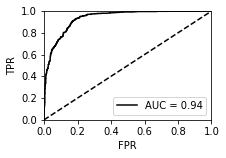

length of current GBS subset: 442


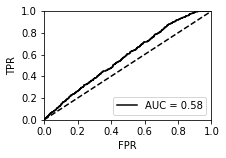

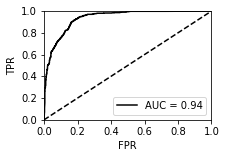

length of current GBS subset: 441


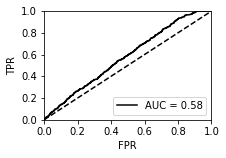

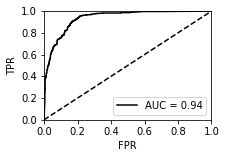

length of current GBS subset: 440


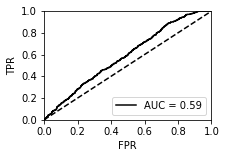

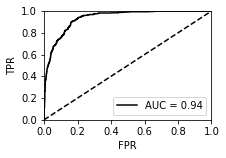

length of current GBS subset: 439


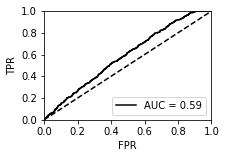

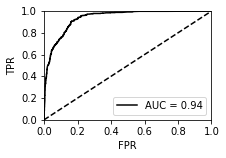

length of current GBS subset: 438


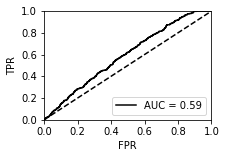

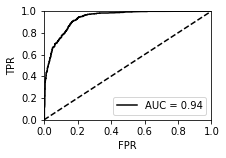

length of current GBS subset: 437


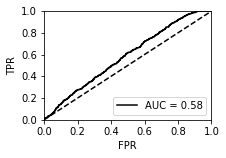

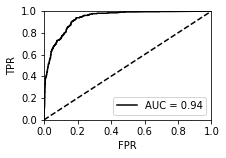

length of current GBS subset: 436


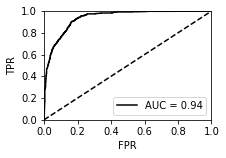

length of current GBS subset: 435


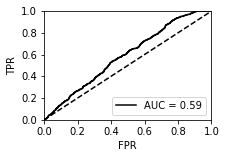

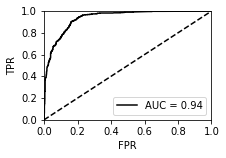

length of current GBS subset: 434


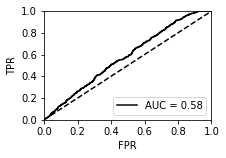

length of current GBS subset: 433


length of current GBS subset: 432


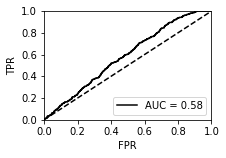

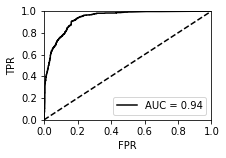

length of current GBS subset: 431


length of current GBS subset: 430


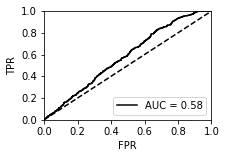

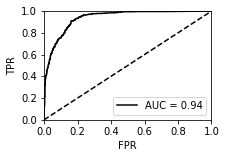

length of current GBS subset: 429


length of current GBS subset: 428


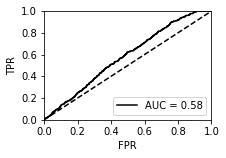

length of current GBS subset: 427


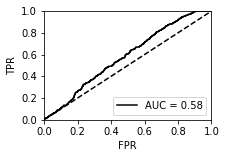

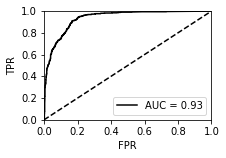

length of current GBS subset: 426


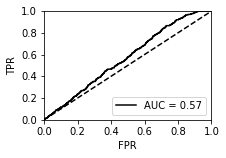

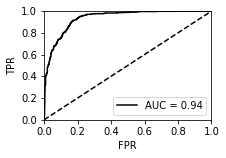

length of current GBS subset: 425


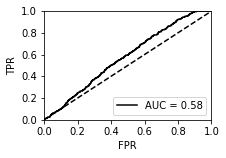

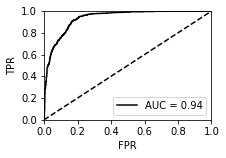

length of current GBS subset: 424


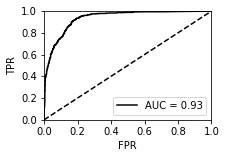

length of current GBS subset: 423


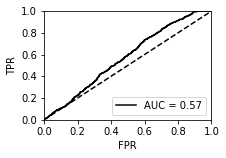

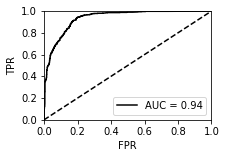

length of current GBS subset: 422


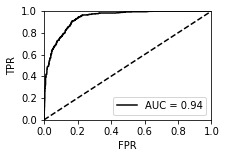

length of current GBS subset: 421


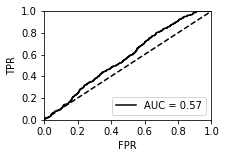

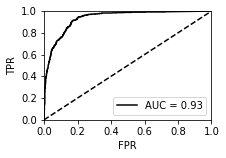

length of current GBS subset: 420


length of current GBS subset: 419


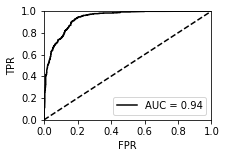

length of current GBS subset: 418


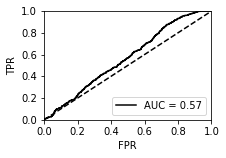

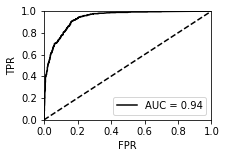

length of current GBS subset: 417


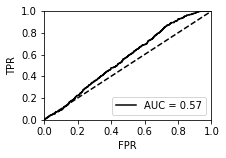

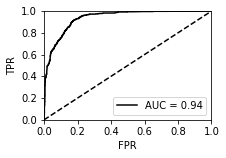

length of current GBS subset: 416


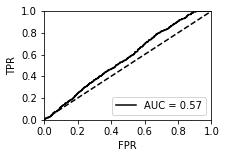

length of current GBS subset: 415


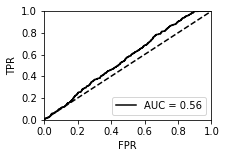

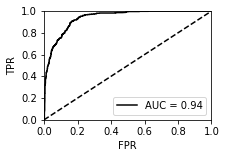

length of current GBS subset: 414


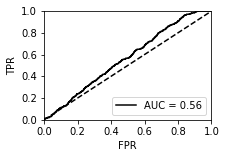

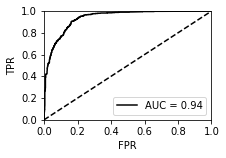

length of current GBS subset: 413


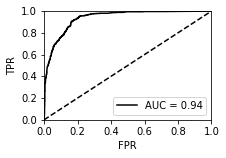

length of current GBS subset: 412


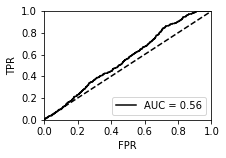

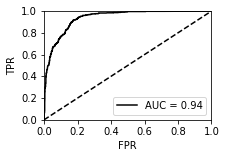

length of current GBS subset: 411


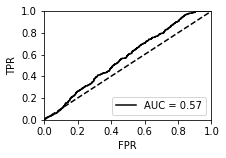

length of current GBS subset: 410


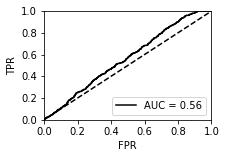

length of current GBS subset: 409


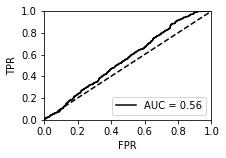

length of current GBS subset: 408


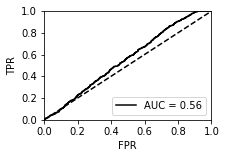

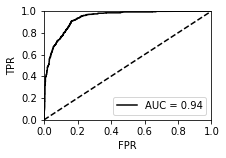

length of current GBS subset: 407


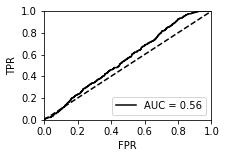

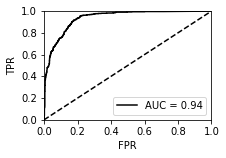

length of current GBS subset: 406


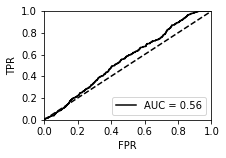

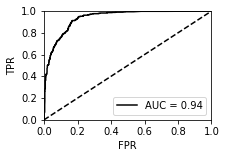

length of current GBS subset: 405


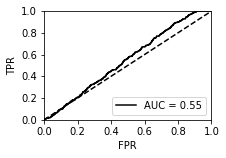

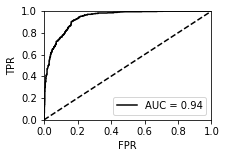

length of current GBS subset: 404


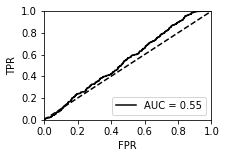

length of current GBS subset: 403


length of current GBS subset: 402


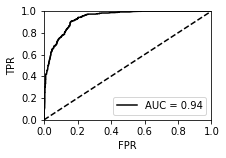

length of current GBS subset: 401


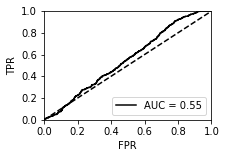

length of current GBS subset: 400


length of current GBS subset: 399


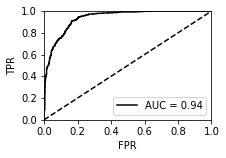

length of current GBS subset: 398


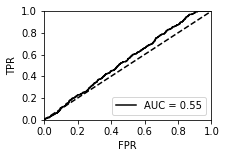

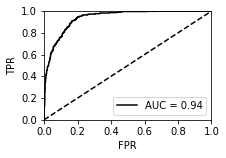

length of current GBS subset: 397


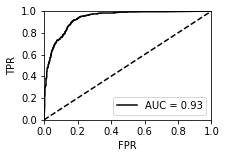

length of current GBS subset: 396


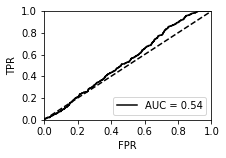

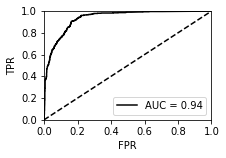

length of current GBS subset: 395


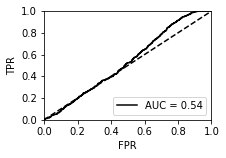

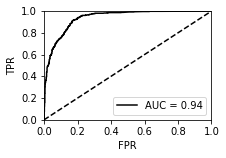

length of current GBS subset: 394


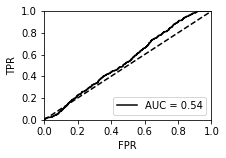

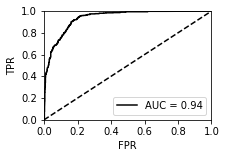

length of current GBS subset: 393


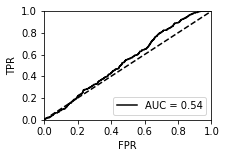

length of current GBS subset: 392


length of current GBS subset: 391


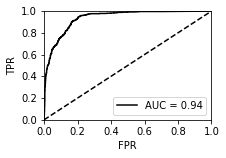

length of current GBS subset: 390


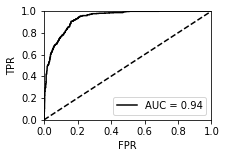

length of current GBS subset: 389


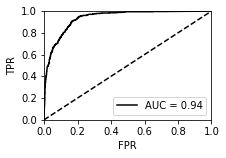

length of current GBS subset: 388


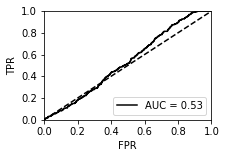

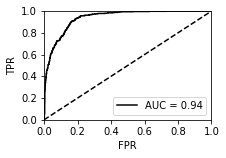

length of current GBS subset: 387


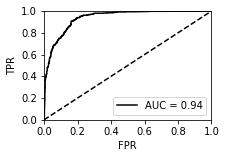

length of current GBS subset: 386


length of current GBS subset: 385


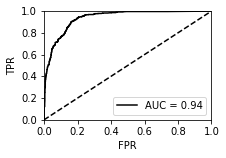

length of current GBS subset: 384


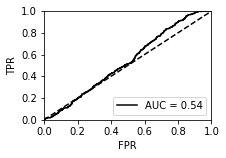

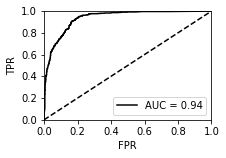

length of current GBS subset: 383


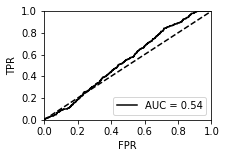

length of current GBS subset: 382


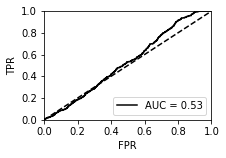

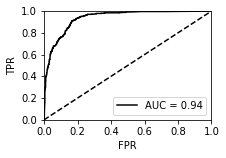

length of current GBS subset: 381


length of current GBS subset: 380


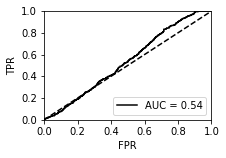

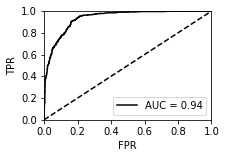

length of current GBS subset: 379


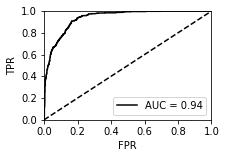

length of current GBS subset: 378


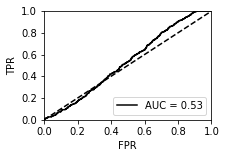

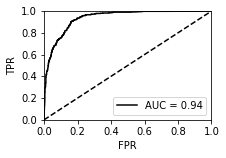

length of current GBS subset: 377


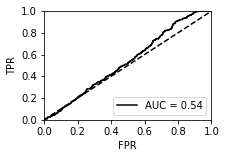

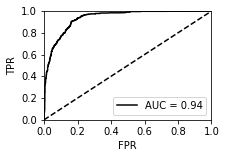

length of current GBS subset: 376


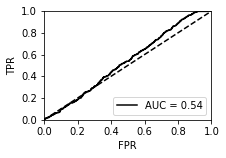

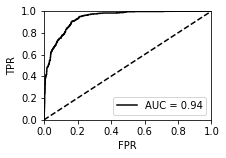

length of current GBS subset: 375


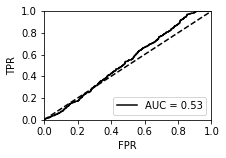

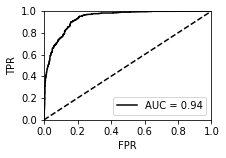

length of current GBS subset: 374


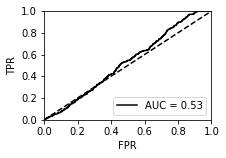

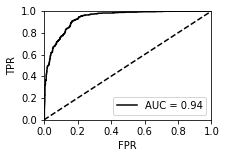

length of current GBS subset: 373


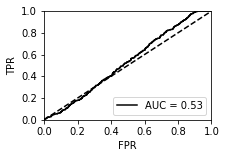

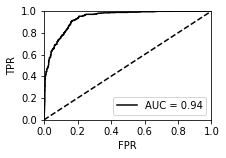

length of current GBS subset: 372


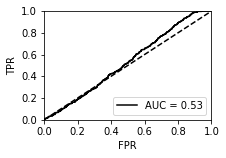

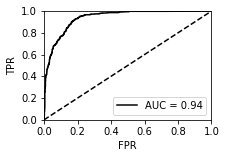

length of current GBS subset: 371


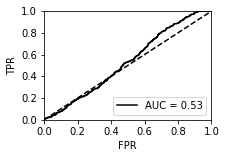

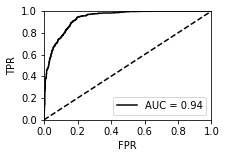

length of current GBS subset: 370


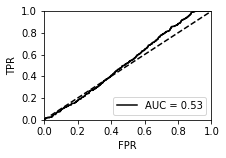

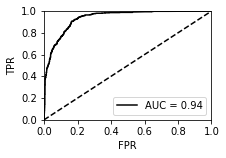

length of current GBS subset: 369


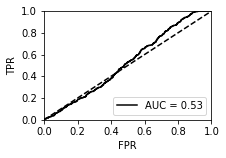

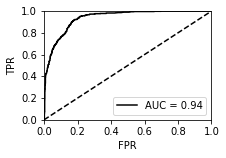

length of current GBS subset: 368


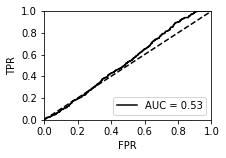

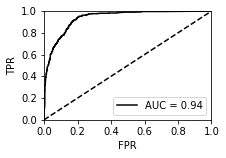

length of current GBS subset: 367


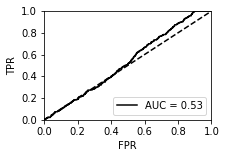

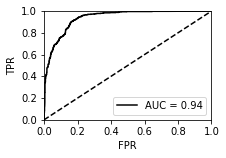

length of current GBS subset: 366


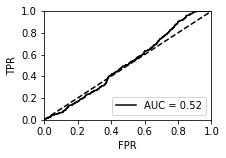

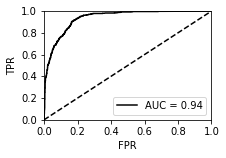

length of current GBS subset: 365


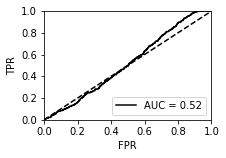

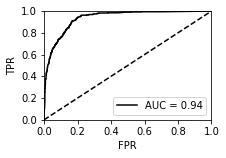

length of current GBS subset: 364


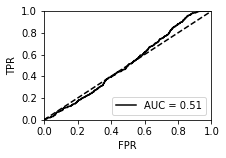

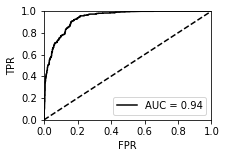

length of current GBS subset: 363


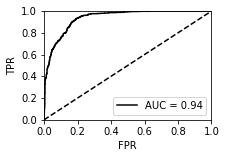

length of current GBS subset: 362


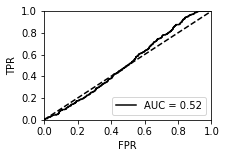

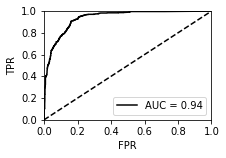

length of current GBS subset: 361


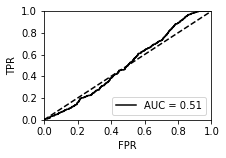

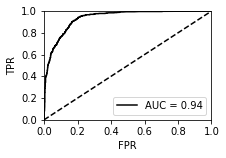

length of current GBS subset: 360


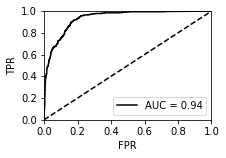

length of current GBS subset: 359


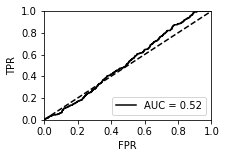

length of current GBS subset: 358


KeyboardInterrupt: 

In [58]:
temperature = 1 
max_drop = 1

ks = []
auc_train = []
auc_test =[]
subset = []


while (len(data[data.label == 'nonrep']) > max_drop):

    rf = RandomForestClassifier(n_estimators=250, 
                                bootstrap=True,
                                max_depth=10,
                                oob_score=True,
                                n_jobs=-1)
    
    probs = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=3,
                              method='predict_proba')
    
    preds = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=3)
    
    test_preds = cross_val_predict(rf,
                              test.drop(['label', 'probs'], axis=1),
                              test['label'], 
                              cv=3,
                              method='predict_proba')
    
    if preds[0] == 'nonrep' and round(probs[0][0], 0) == 1:
        data['probs'] = [p[1] for p in probs]
    else:
        data['probs'] = [p[0] for p in probs]
    
    drop_id = []
    for _ in range(max_drop):
        softmax = sample(data[data.label == 'nonrep']['probs'], temperature)
        drop = data[data.label == 'nonrep'].iloc[[np.argmax(softmax)]].index[0]
        drop_id.append(drop)
        
    data.drop(data.index[drop_id], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    #################################################################
    # EVALUATION
    subset.append(len(data[data.label == 'nonrep']))
    
    auc_train.append(roc([1 if k == 'nonrep' else 0 for k in data.label], data.probs, 1, 'name'))    
    auc_test.append(roc([1 if k == 'nonrep' else 0 for k in test.label], [a[0] for a in test_preds], 1, 'name'))    

    if drop_id in test.index.values:
        test.drop(test.index[drop_id], inplace=True)
        test.reset_index(drop=True, inplace=True)
    
    ks.append(stats.ks_2samp(data[data.label == 'nonrep']['probs'], 
                             data[data.label == 'rep']['probs']))
    
    print('length of current GBS subset:', len(data[data.label == 'nonrep'].label))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(auc_train, color='red')
plt.plot(auc_test, color="blue")
plt.xlabel("number of iterations")
plt.ylabel('auc')
plt.show()